# Лабораторная работа №1 Домкин Павел М8О-310Б-23

# Импорт

In [120]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder
import warnings

warnings.filterwarnings('ignore')

# Анализ

Размер обучающей выборки: (11017, 35)
Размер тестовой выборки: (5000, 35)

Первые строки датасета:
  ApplicationDate   Age  AnnualIncome  CreditScore  LoanAmount  LoanDuration  \
0      2010-06-26  27.0       66829.0        549.0     17290.0          60.0   
1      1996-09-23  55.0      172147.0        850.0     16110.0          36.0   
2      2015-01-19  51.0      300000.0        850.0     38436.0          36.0   
3      1981-05-12  25.0       34683.0        847.0     19186.0          48.0   

  MaritalStatus  NumberOfDependents HomeOwnershipStatus  MonthlyDebtPayments  \
0      Divorced                 1.0                Rent               1095.0   
1       Widowed                 1.0            Mortgage                211.0   
2       Married                 0.0            Mortgage                546.0   
3       Married                 0.0               Other                153.0   

   ...  JobTenure  EmploymentStatus  EducationLevel  Experience  NetWorth  \
0  ...        4.0     

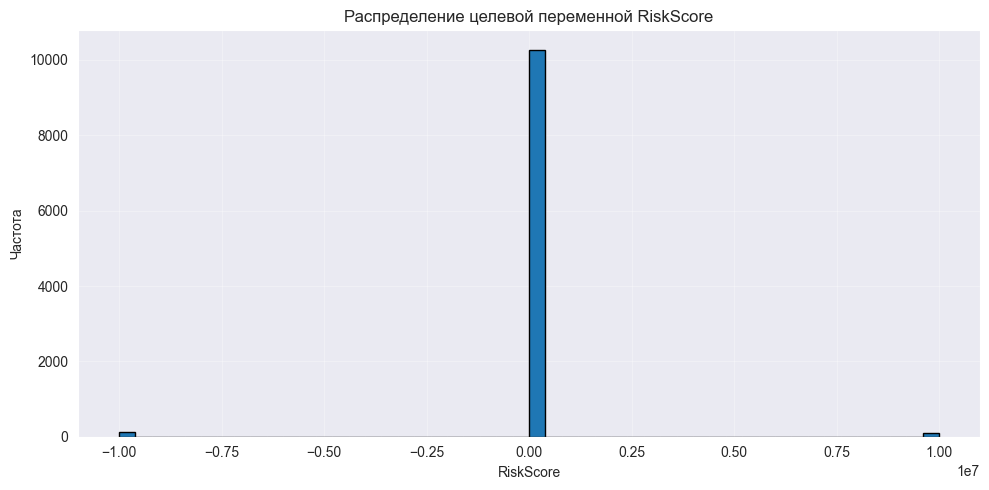


Статистика RiskScore:
Среднее: -25698.78
Медиана: 44.12
Стандартное отклонение: 1431674.59
Мин: -9999999.00, Макс: 10000000.00


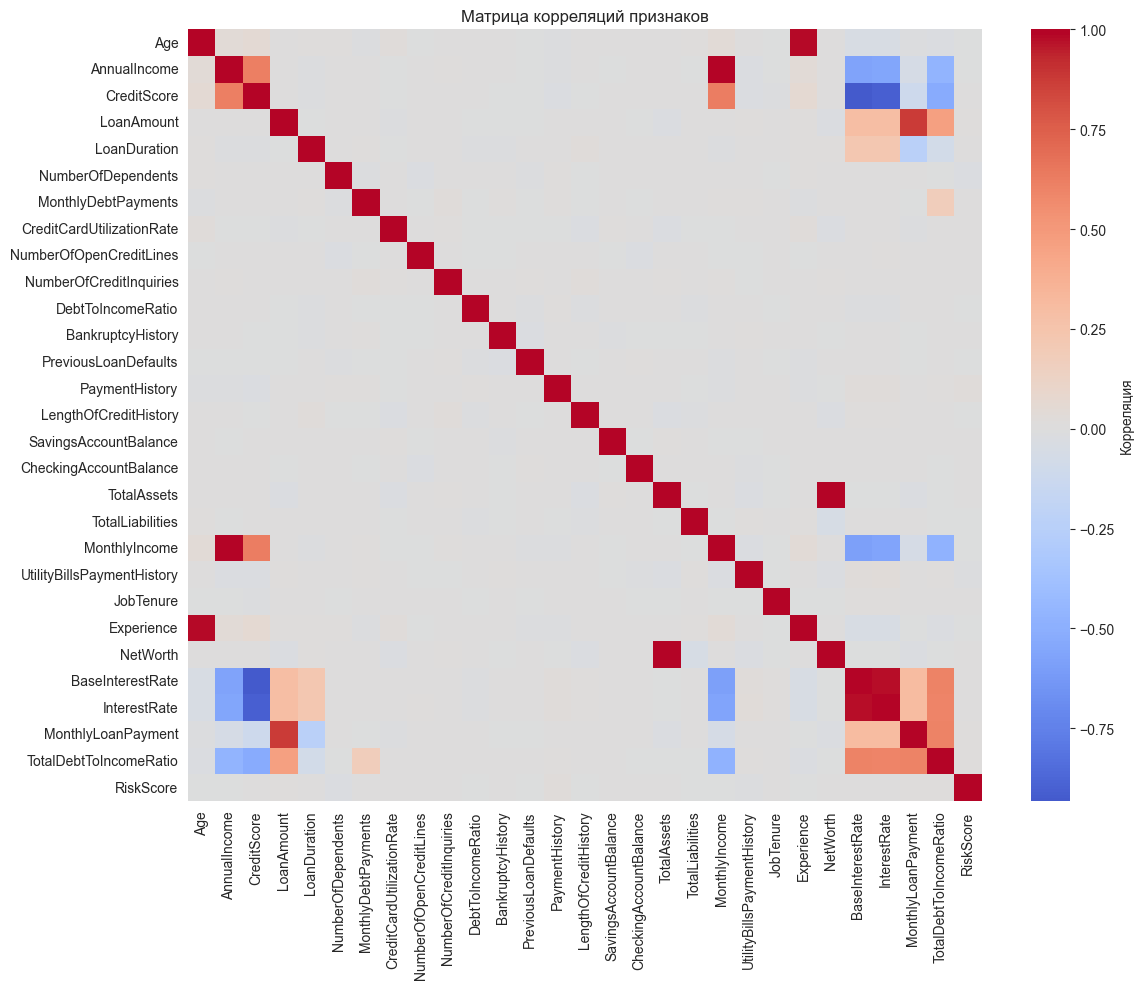


Топ-10 признаков по корреляции с RiskScore:
RiskScore                     1.000000
NumberOfDependents            0.023314
PaymentHistory                0.019144
TotalDebtToIncomeRatio        0.013879
UtilityBillsPaymentHistory    0.013865
MonthlyLoanPayment            0.012366
LoanAmount                    0.011771
NumberOfCreditInquiries       0.011055
LengthOfCreditHistory         0.009448
NetWorth                      0.008804
AnnualIncome                  0.008460
Name: RiskScore, dtype: float64


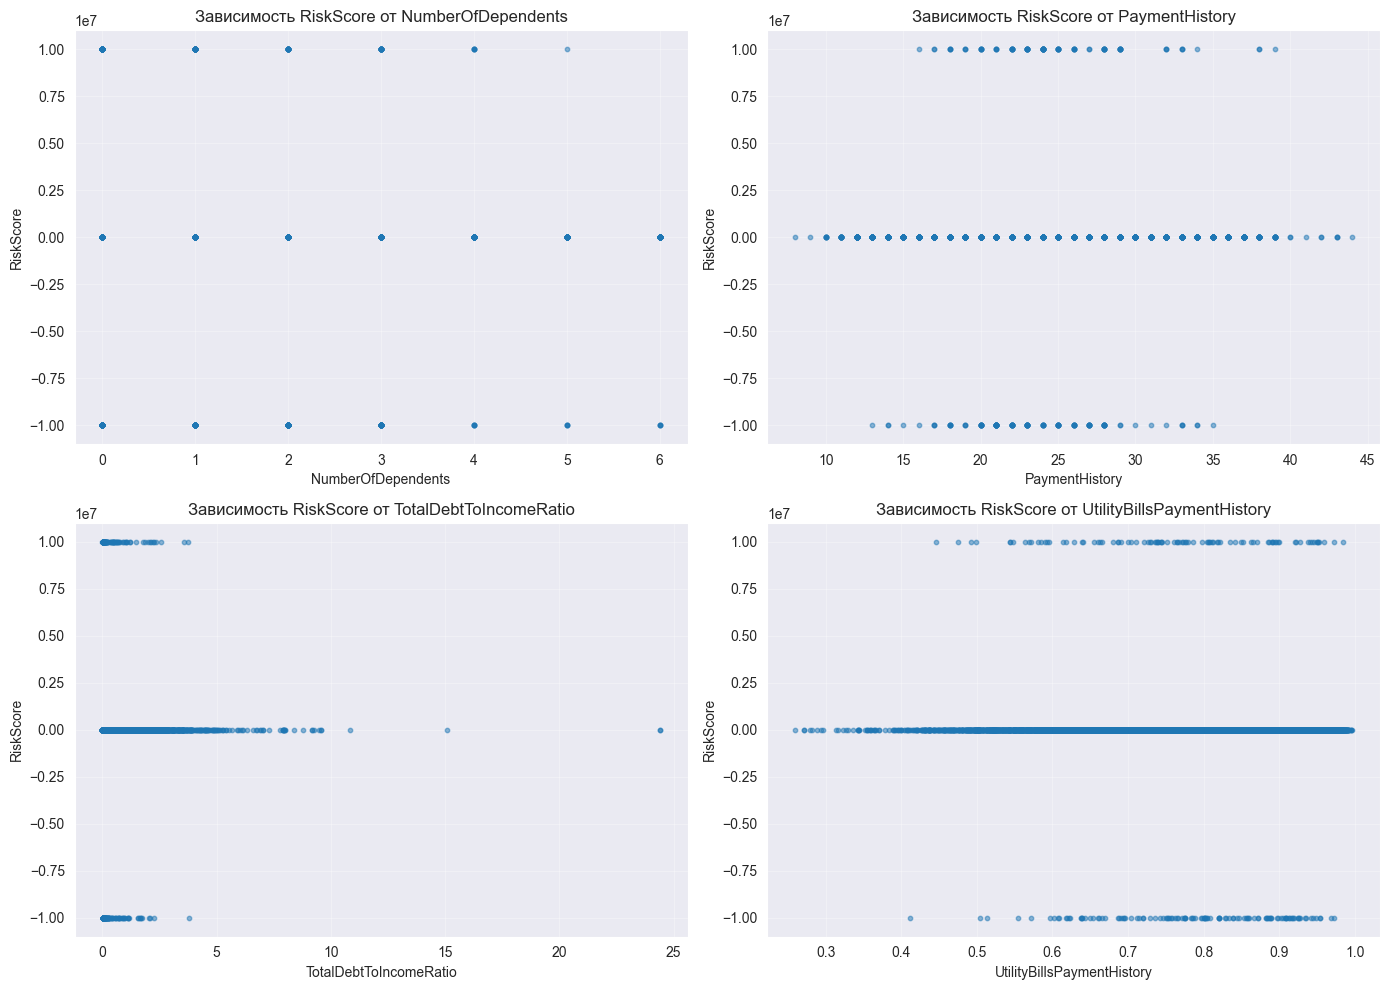

In [121]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

print(f"Размер обучающей выборки: {train_df.shape}")
print(f"Размер тестовой выборки: {test_df.shape}")
print("\nПервые строки датасета:")
print(train_df.head(4))

# ============================================================================
# 2. РАЗВЕДОЧНЫЙ АНАЛИЗ ДАННЫХ (EDA)
# ============================================================================
print("\n" + "=" * 80)
print("РАЗВЕДОЧНЫЙ АНАЛИЗ ДАННЫХ (EDA)")
print("=" * 80)

print("\nПропущенные значения:")
print(train_df.isnull().sum())

# График целевой переменной
plt.figure(figsize=(10, 5))
plt.hist(train_df['RiskScore'], bins=50, edgecolor='black')
plt.xlabel('RiskScore')
plt.ylabel('Частота')
plt.title('Распределение целевой переменной RiskScore')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nСтатистика RiskScore:")
print(f"Среднее: {train_df['RiskScore'].mean():.2f}")
print(f"Медиана: {train_df['RiskScore'].median():.2f}")
print(f"Стандартное отклонение: {train_df['RiskScore'].std():.2f}")
print(f"Мин: {train_df['RiskScore'].min():.2f}, Макс: {train_df['RiskScore'].max():.2f}")

# Матрица корреляций
numeric_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()
correlation_matrix = train_df[numeric_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0,
            cbar_kws={'label': 'Корреляция'})
plt.title('Матрица корреляций признаков')
plt.tight_layout()
plt.show()

if 'RiskScore' in correlation_matrix.columns:
    corr_with_target = correlation_matrix['RiskScore'].abs().sort_values(ascending=False)
    print("\nТоп-10 признаков по корреляции с RiskScore:")
    print(corr_with_target.head(11))

top_features = corr_with_target.index[1:5]
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

for idx, feature in enumerate(top_features):
    axes[idx].scatter(train_df[feature], train_df['RiskScore'], alpha=0.5, s=10)
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel('RiskScore')
    axes[idx].set_title(f'Зависимость RiskScore от {feature}')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Метрики

In [122]:
def mse_custom(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def mae_custom(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def r2_custom(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - (ss_res / ss_tot)

def mape_custom(y_true, y_pred):
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

In [123]:
y_true_test = np.array([3, -0.5, 2, 7])
y_pred_test = np.array([2.5, 0.0, 2, 8])

print("\nТестовые данные:")
print(f"y_true: {y_true_test}")
print(f"y_pred: {y_pred_test}")

print("\nMSE:")
print(f"Своя реализация: {mse_custom(y_true_test, y_pred_test):.6f}")
print(f"Sklearn:         {mean_squared_error(y_true_test, y_pred_test):.6f}")
print(f"Разница:         {abs(mse_custom(y_true_test, y_pred_test) - mean_squared_error(y_true_test, y_pred_test)):.4f}")

print("\nMAE:")
print(f"Своя реализация: {mae_custom(y_true_test, y_pred_test):.6f}")
print(f"Sklearn:         {mean_absolute_error(y_true_test, y_pred_test):.6f}")
print(f"Разница:         {abs(mae_custom(y_true_test, y_pred_test) - mean_absolute_error(y_true_test, y_pred_test)):.4f}")

print("\nR²:")
print(f"Своя реализация: {r2_custom(y_true_test, y_pred_test):.6f}")
print(f"Sklearn:         {r2_score(y_true_test, y_pred_test):.6f}")
print(f"Разница:         {abs(r2_custom(y_true_test, y_pred_test) - r2_score(y_true_test, y_pred_test)):.4f}")

print("\nMAPE:")
print(f"Своя реализация: {mape_custom(y_true_test, y_pred_test):.6f}%")
print(f"Sklearn:         {(mean_absolute_percentage_error(y_true_test, y_pred_test) * 100):.6f}%")
print(f"Разница:         {abs(mape_custom(y_true_test, y_pred_test) - mean_absolute_percentage_error(y_true_test, y_pred_test) * 100):.4f}%")


Тестовые данные:
y_true: [ 3.  -0.5  2.   7. ]
y_pred: [2.5 0.  2.  8. ]

MSE:
Своя реализация: 0.375000
Sklearn:         0.375000
Разница:         0.0000

MAE:
Своя реализация: 0.500000
Sklearn:         0.500000
Разница:         0.0000

R²:
Своя реализация: 0.948608
Sklearn:         0.948608
Разница:         0.0000

MAPE:
Своя реализация: 32.738095%
Sklearn:         32.738095%
Разница:         0.0000%


# Нормализация данных

In [124]:
class DataNormalizer:
    def __init__(self, method='zscore'):
        self.method = method
        self.params = {}

    def fit(self, X):
        if self.method == 'zscore':
            self.params['mean'] = np.mean(X, axis=0)
            self.params['std'] = np.std(X, axis=0)
        elif self.method == 'minmax':
            self.params['min'] = np.min(X, axis=0)
            self.params['max'] = np.max(X, axis=0)
        return self

    def transform(self, X):
        if self.method == 'zscore':
            std = self.params['std'].copy()
            std[std == 0] = 1
            return (X - self.params['mean']) / std
        elif self.method == 'minmax':
            range_val = self.params['max'] - self.params['min']
            range_val[range_val == 0] = 1
            return (X - self.params['min']) / range_val

    def fit_transform(self, X):
        return self.fit(X).transform(X)

In [125]:
test_data = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
print("\nТестовые данные:")
print(test_data)

# Z-score нормализация
normalizer_zscore = DataNormalizer(method='zscore')
normalized_zscore = normalizer_zscore.fit_transform(test_data)
print("\nZ-score нормализация:")
print(normalized_zscore)
print("Среднее:", np.mean(normalized_zscore, axis=0))
print("Std:", np.std(normalized_zscore, axis=0))

# Min-Max нормализация
normalizer_minmax = DataNormalizer(method='minmax')
normalized_minmax = normalizer_minmax.fit_transform(test_data)
print("\nMin-Max нормализация:")
print(normalized_minmax)
print("Мин:", np.min(normalized_minmax, axis=0))
print("Макс:", np.max(normalized_minmax, axis=0))



Тестовые данные:
[[1 2 3]
 [4 5 6]
 [7 8 9]]

Z-score нормализация:
[[-1.22474487 -1.22474487 -1.22474487]
 [ 0.          0.          0.        ]
 [ 1.22474487  1.22474487  1.22474487]]
Среднее: [0. 0. 0.]
Std: [1. 1. 1.]

Min-Max нормализация:
[[0.  0.  0. ]
 [0.5 0.5 0.5]
 [1.  1.  1. ]]
Мин: [0. 0. 0.]
Макс: [1. 1. 1.]


# Линейная регрессия

In [126]:
class LinearRegressionCustom:
    """Класс линейной регрессии с различными методами обучения"""

    def __init__(self, method='analytical', learning_rate=0.01, n_iterations=1000,
                 batch_size=32, regularization=None, lambda_reg=0.01, p_norm=2):
        """
        method: 'analytical', 'gradient_descent', 'sgd'
        regularization: None, 'l1', 'l2', 'elastic', 'lp'
        """
        self.method = method
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.batch_size = batch_size
        self.weights = None
        self.bias = None
        self.regularization = regularization
        self.lambda_reg = lambda_reg
        self.p_norm = p_norm
        self.loss_history = []

    def fit(self, X, y):
        """Обучение модели"""
        n_samples, n_features = X.shape

        if self.method == 'analytical':
            self._fit_analytical(X, y)
        elif self.method == 'gradient_descent':
            self._fit_gradient_descent(X, y)
        elif self.method == 'sgd':
            self._fit_sgd(X, y)

        return self

    def _fit_analytical(self, X, y):
        """Аналитическое решение через нормальное уравнение"""
        # Добавляем столбец единиц для bias
        X_b = np.c_[np.ones((X.shape[0], 1)), X]

        if self.regularization == 'l2':
            # Ridge regression: (X^T X + λI)^-1 X^T y
            I = np.eye(X_b.shape[1])
            I[0, 0] = 0  # Не регуляризуем bias
            # Используем pinv для большей устойчивости
            theta = np.linalg.pinv(X_b.T @ X_b + self.lambda_reg * I) @ X_b.T @ y
        else:
            # Обычная регрессия: (X^T X)^-1 X^T y
            # Используем pinv вместо inv для большей устойчивости (как в lab1.ipynb)
            theta = np.linalg.pinv(X_b.T @ X_b) @ X_b.T @ y

        self.bias = theta[0]
        self.weights = theta[1:]

    def _fit_gradient_descent(self, X, y):
        """Градиентный спуск"""
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0
        self.loss_history = []

        for iteration in range(self.n_iterations):
            # Предсказания
            y_pred = X @ self.weights + self.bias

            # Градиенты
            dw = (1 / n_samples) * (X.T @ (y_pred - y))
            db = (1 / n_samples) * np.sum(y_pred - y)

            # Добавляем регуляризацию к градиентам
            if self.regularization == 'l1':
                dw += self.lambda_reg * np.sign(self.weights)
            elif self.regularization == 'l2':
                dw += 2 * self.lambda_reg * self.weights
            elif self.regularization == 'elastic':
                dw += self.lambda_reg * (0.5 * np.sign(self.weights) + self.weights)
            elif self.regularization == 'lp':
                dw += self.lambda_reg * self.p_norm * np.sign(self.weights) * (
                        np.abs(self.weights) ** (self.p_norm - 1))

            # Обновление параметров
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

            # Сохраняем loss
            if iteration % 100 == 0:
                loss = mse_custom(y, y_pred)
                self.loss_history.append(loss)

    def _fit_sgd(self, X, y):
        """Стохастический градиентный спуск"""
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0
        self.loss_history = []

        for iteration in range(self.n_iterations):
            # Перемешиваем данные
            indices = np.random.permutation(n_samples)
            X_shuffled = X[indices]
            y_shuffled = y[indices]

            # Мини-батчи
            for i in range(0, n_samples, self.batch_size):
                X_batch = X_shuffled[i:i + self.batch_size]
                y_batch = y_shuffled[i:i + self.batch_size]

                # Предсказания
                y_pred = X_batch @ self.weights + self.bias

                # Градиенты
                batch_size_actual = X_batch.shape[0]
                dw = (1 / batch_size_actual) * (X_batch.T @ (y_pred - y_batch))
                db = (1 / batch_size_actual) * np.sum(y_pred - y_batch)

                # Добавляем регуляризацию
                if self.regularization == 'l1':
                    dw += self.lambda_reg * np.sign(self.weights)
                elif self.regularization == 'l2':
                    dw += 2 * self.lambda_reg * self.weights
                elif self.regularization == 'elastic':
                    dw += self.lambda_reg * (0.5 * np.sign(self.weights) + self.weights)
                elif self.regularization == 'lp':
                    dw += self.lambda_reg * self.p_norm * np.sign(self.weights) * (
                            np.abs(self.weights) ** (self.p_norm - 1))

                # Обновление
                self.weights -= self.learning_rate * dw
                self.bias -= self.learning_rate * db

            # Сохраняем loss
            if iteration % 100 == 0:
                y_pred_all = X @ self.weights + self.bias
                loss = mse_custom(y, y_pred_all)
                self.loss_history.append(loss)

    def predict(self, X):
        """Предсказание"""
        return X @ self.weights + self.bias

In [127]:
np.random.seed(42)
X_simple = np.random.randn(100, 3)
y_simple = 3 * X_simple[:, 0] + 2 * X_simple[:, 1] - X_simple[:, 2] + 5 + np.random.randn(100) * 0.1

methods = ['analytical', 'gradient_descent', 'sgd']
results = {}

for method in methods:
    if method == 'analytical':
        model = LinearRegressionCustom(method=method)
    else:
        model = LinearRegressionCustom(method=method, learning_rate=0.1, n_iterations=1000)

    model.fit(X_simple, y_simple)
    y_pred = model.predict(X_simple)
    mse = mse_custom(y_simple, y_pred)
    results[method] = mse

    print(f"\n{method.upper()}:")
    print(f"  MSE: {mse:.6f}")
    print(f"  Weights: {model.weights}")
    print(f"  Bias: {model.bias:.4f}")

# Сравнение со sklearn
print("\nSKLEARN:")
sklearn_model = LinearRegression()
sklearn_model.fit(X_simple, y_simple)
y_pred_sklearn = sklearn_model.predict(X_simple)
mse_sklearn = mean_squared_error(y_simple, y_pred_sklearn)
print(f"  MSE: {mse_sklearn:.6f}")
print(f"  Weights: {sklearn_model.coef_}")
print(f"  Bias: {sklearn_model.intercept_:.4f}")


ANALYTICAL:
  MSE: 0.007568
  Weights: [ 2.99223367  1.99500364 -1.01075933]
  Bias: 5.0113

GRADIENT_DESCENT:
  MSE: 0.007568
  Weights: [ 2.99223367  1.99500364 -1.01075933]
  Bias: 5.0113

SGD:
  MSE: 0.007687
  Weights: [ 2.99950615  1.99781927 -1.01510212]
  Bias: 5.0182

SKLEARN:
  MSE: 0.007568
  Weights: [ 2.99223367  1.99500364 -1.01075933]
  Bias: 5.0113


# Кроссвалидация

In [128]:
class CrossValidation:
    """Класс для кросс-валидации"""

    @staticmethod
    def k_fold(X, y, k=5):
        """K-Fold кросс-валидация"""
        n_samples = len(X)
        indices = np.arange(n_samples)
        np.random.shuffle(indices)

        fold_size = n_samples // k
        folds = []

        for i in range(k):
            start_idx = i * fold_size
            end_idx = start_idx + fold_size if i < k - 1 else n_samples

            test_indices = indices[start_idx:end_idx]
            train_indices = np.concatenate([indices[:start_idx], indices[end_idx:]])

            folds.append({
                'train': (X[train_indices], y[train_indices]),
                'test': (X[test_indices], y[test_indices])
            })

        return folds

    @staticmethod
    def leave_one_out(X, y):
        """Leave-One-Out кросс-валидация"""
        n_samples = len(X)
        folds = []

        for i in range(n_samples):
            test_indices = [i]
            train_indices = list(range(i)) + list(range(i + 1, n_samples))

            folds.append({
                'train': (X[train_indices], y[train_indices]),
                'test': (X[[i]], y[[i]])
            })

        return folds

    @staticmethod
    def evaluate(model, folds, metric_func=mse_custom):
        """Оценка модели на фолдах"""
        scores = []

        for fold in folds:
            X_train, y_train = fold['train']
            X_test, y_test = fold['test']

            # Обучаем модель
            model.fit(X_train, y_train)

            # Предсказываем
            y_pred = model.predict(X_test)

            # Считаем метрику
            score = metric_func(y_test, y_pred)
            scores.append(score)

        return scores

In [129]:
# Тестирование кросс-валидации
print("\nТестирование K-Fold:")
folds_kfold = CrossValidation.k_fold(X_simple, y_simple, k=5)
print(f"Количество фолдов: {len(folds_kfold)}")

model = LinearRegressionCustom(method='analytical')
scores = CrossValidation.evaluate(model, folds_kfold, mse_custom)
print(f"MSE по фолдам: {[f'{s:.4f}' for s in scores]}")
print(f"Средний MSE: {np.mean(scores):.4f} ± {np.std(scores):.4f}")

# Сравнение со sklearn KFold
print("\nСравнение со sklearn KFold:")
from sklearn.model_selection import cross_val_score

sklearn_model = LinearRegression()
sklearn_scores = -cross_val_score(sklearn_model, X_simple, y_simple,
                                  cv=5, scoring='neg_mean_squared_error')
print(f"Sklearn MSE: {np.mean(sklearn_scores):.4f} ± {np.std(sklearn_scores):.4f}")

print("\nТестирование Leave-One-Out:")
X_small = X_simple[:20]
y_small = y_simple[:20]
folds_loo = CrossValidation.leave_one_out(X_small, y_small)
print(f"Количество фолдов: {len(folds_loo)}")

model = LinearRegressionCustom(method='analytical')
scores_loo = CrossValidation.evaluate(model, folds_loo, mse_custom)
print(f"Средний MSE (LOO): {np.mean(scores_loo):.4f}")


Тестирование K-Fold:
Количество фолдов: 5
MSE по фолдам: ['0.0069', '0.0082', '0.0090', '0.0086', '0.0077']
Средний MSE: 0.0081 ± 0.0007

Сравнение со sklearn KFold:
Sklearn MSE: 0.0085 ± 0.0031

Тестирование Leave-One-Out:
Количество фолдов: 20
Средний MSE (LOO): 0.0059


# Подготовка данных к обучению

In [130]:
train_df = train_df.drop_duplicates()
test_df = test_df.drop_duplicates()

if train_df['RiskScore'].isnull().sum() > 0:
    train_df = train_df.dropna(subset=['RiskScore'])

Q1 = train_df['RiskScore'].quantile(0.25)
Q3 = train_df['RiskScore'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outlier_mask = (train_df['RiskScore'] >= lower_bound) & (train_df['RiskScore'] <= upper_bound)
removed_count = (~outlier_mask).sum()
train_df = train_df[outlier_mask].reset_index(drop=True)

if 'ApplicationDate' in train_df.columns:
    train_df['ApplicationDate'] = pd.to_datetime(train_df['ApplicationDate'], errors='coerce')
    train_df['ApplicationYear'] = train_df['ApplicationDate'].dt.year
    train_df['ApplicationMonth'] = train_df['ApplicationDate'].dt.month
    train_df['ApplicationDay'] = train_df['ApplicationDate'].dt.day
    train_df = train_df.drop('ApplicationDate', axis=1)

if 'ApplicationDate' in test_df.columns:
    test_df['ApplicationDate'] = pd.to_datetime(test_df['ApplicationDate'], errors='coerce')
    test_df['ApplicationYear'] = test_df['ApplicationDate'].dt.year
    test_df['ApplicationMonth'] = test_df['ApplicationDate'].dt.month
    test_df['ApplicationDay'] = test_df['ApplicationDate'].dt.day
    test_df = test_df.drop('ApplicationDate', axis=1)

X_train = train_df.drop('RiskScore', axis=1)
y_train = train_df['RiskScore'].values
X_test = test_df.copy()

test_ids = X_test['id'] if 'id' in X_test.columns else None

numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
non_numeric_cols = X_train.select_dtypes(exclude=[np.number]).columns.tolist()

if 'id' in X_train.columns:
    X_train = X_train.drop('id', axis=1)
if 'id' in X_test.columns:
    X_test = X_test.drop('id', axis=1)

# Заполняем пропущенные значения медианой для численных
for col in numeric_cols:
    if col in X_train.columns and X_train[col].isnull().sum() > 0:
        median_val = X_train[col].median()
        if pd.isna(median_val):
            median_val = 0
        X_train[col].fillna(median_val, inplace=True)
        if col in X_test.columns:
            X_test[col].fillna(median_val, inplace=True)

# Заполняем пропущенные значения модой для категориальных
for col in non_numeric_cols:
    if col in X_train.columns and X_train[col].isnull().sum() > 0:
        mode_val = X_train[col].mode()[0] if len(X_train[col].mode()) > 0 else 'Unknown'
        X_train[col].fillna(mode_val, inplace=True)
        if col in X_test.columns:
            X_test[col].fillna(mode_val, inplace=True)

log_cols = ['MonthlyLoanPayment', 'TotalAssets', 'TotalLiabilities', 'NetWorth',
            'LoanAmount', 'MonthlyDebtPayments', 'SavingsAccountBalance', 'CheckingAccountBalance']

for col in log_cols:
    if col in X_train.columns:
        X_train[col] = np.log1p(X_train[col])
        X_test[col] = np.log1p(X_test[col])

print("\n Создаём дополнительные признаки...")
original_features = X_train.shape[1]

important_numeric = ['Age', 'AnnualIncome', 'CreditScore', 'LoanAmount',
                     'DebtToIncomeRatio', 'CreditCardUtilizationRate',
                     'MonthlyIncome', 'MonthlyDebtPayments']

for feat in important_numeric:
    if feat in X_train.columns:
        X_train[f'{feat}_squared'] = X_train[feat] ** 2
        X_test[f'{feat}_squared'] = X_test[feat] ** 2

if 'AnnualIncome' in X_train.columns and 'LoanAmount' in X_train.columns:
    X_train['Income_to_Loan'] = X_train['AnnualIncome'] / (X_train['LoanAmount'] + 1)
    X_test['Income_to_Loan'] = X_test['AnnualIncome'] / (X_test['LoanAmount'] + 1)

if 'CreditScore' in X_train.columns and 'DebtToIncomeRatio' in X_train.columns:
    X_train['Credit_Debt_Ratio'] = X_train['CreditScore'] * X_train['DebtToIncomeRatio']
    X_test['Credit_Debt_Ratio'] = X_test['CreditScore'] * X_test['DebtToIncomeRatio']

if 'MonthlyIncome' in X_train.columns and 'MonthlyDebtPayments' in X_train.columns:
    X_train['Income_Debt_Ratio'] = X_train['MonthlyIncome'] / (X_train['MonthlyDebtPayments'] + 1)
    X_test['Income_Debt_Ratio'] = X_test['MonthlyIncome'] / (X_test['MonthlyDebtPayments'] + 1)

if 'Age' in X_train.columns and 'CreditScore' in X_train.columns:
    X_train['Age_Credit_Interaction'] = X_train['Age'] * X_train['CreditScore']
    X_test['Age_Credit_Interaction'] = X_test['Age'] * X_test['CreditScore']

if 'TotalAssets' in X_train.columns and 'TotalLiabilities' in X_train.columns:
    X_train['Assets_Liabilities_Ratio'] = X_train['TotalAssets'] / (X_train['TotalLiabilities'] + 1)
    X_test['Assets_Liabilities_Ratio'] = X_test['TotalAssets'] / (X_test['TotalLiabilities'] + 1)

if 'Age' in X_train.columns and 'AnnualIncome' in X_train.columns:
    X_train['Age_Income'] = X_train['Age'] * X_train['AnnualIncome']
    X_test['Age_Income'] = X_test['Age'] * X_test['AnnualIncome']

if 'CreditScore' in X_train.columns and 'LoanAmount' in X_train.columns:
    X_train['Credit_Loan'] = X_train['CreditScore'] * X_train['LoanAmount']
    X_test['Credit_Loan'] = X_test['CreditScore'] * X_test['LoanAmount']

if 'DebtToIncomeRatio' in X_train.columns and 'MonthlyIncome' in X_train.columns:
    X_train['Debt_MonthlyIncome'] = X_train['DebtToIncomeRatio'] * X_train['MonthlyIncome']
    X_test['Debt_MonthlyIncome'] = X_test['DebtToIncomeRatio'] * X_test['MonthlyIncome']

if 'CreditCardUtilizationRate' in X_train.columns and 'CreditScore' in X_train.columns:
    X_train['Utilization_Credit'] = X_train['CreditCardUtilizationRate'] * X_train['CreditScore']
    X_test['Utilization_Credit'] = X_test['CreditCardUtilizationRate'] * X_test['CreditScore']

if 'NetWorth' in X_train.columns and 'AnnualIncome' in X_train.columns:
    X_train['NetWorth_Income'] = X_train['NetWorth'] / (X_train['AnnualIncome'] + 1)
    X_test['NetWorth_Income'] = X_test['NetWorth'] / (X_test['AnnualIncome'] + 1)

if 'SavingsAccountBalance' in X_train.columns and 'CheckingAccountBalance' in X_train.columns:
    X_train['Savings_Checking'] = X_train['SavingsAccountBalance'] + X_train['CheckingAccountBalance']
    X_test['Savings_Checking'] = X_test['SavingsAccountBalance'] + X_test['CheckingAccountBalance']

if 'MonthlyLoanPayment' in X_train.columns and 'MonthlyIncome' in X_train.columns:
    X_train['Payment_Income_Ratio'] = X_train['MonthlyLoanPayment'] / (X_train['MonthlyIncome'] + 1)
    X_test['Payment_Income_Ratio'] = X_train['MonthlyLoanPayment'] / (X_test['MonthlyIncome'] + 1)

if 'Age' in X_train.columns and 'LoanAmount' in X_train.columns:
    X_train['Age_Loan'] = X_train['Age'] * X_train['LoanAmount']
    X_test['Age_Loan'] = X_test['Age'] * X_test['LoanAmount']

if 'Age' in X_train.columns and 'DebtToIncomeRatio' in X_train.columns:
    X_train['Age_Debt'] = X_train['Age'] * X_train['DebtToIncomeRatio']
    X_test['Age_Debt'] = X_test['Age'] * X_test['DebtToIncomeRatio']

if 'AnnualIncome' in X_train.columns and 'DebtToIncomeRatio' in X_train.columns:
    X_train['Income_Debt_Product'] = X_train['AnnualIncome'] * X_train['DebtToIncomeRatio']
    X_test['Income_Debt_Product'] = X_test['AnnualIncome'] * X_test['DebtToIncomeRatio']

if 'CreditScore' in X_train.columns and 'CreditCardUtilizationRate' in X_train.columns:
    X_train['Credit_Utilization_Product'] = X_train['CreditScore'] * X_train['CreditCardUtilizationRate']
    X_test['Credit_Utilization_Product'] = X_test['CreditScore'] * X_test['CreditCardUtilizationRate']
    print(f"  Добавлен признак: Credit_Utilization_Product")

if 'MonthlyIncome' in X_train.columns and 'LoanAmount' in X_train.columns:
    X_train['MonthlyIncome_Loan_Ratio'] = X_train['MonthlyIncome'] / (X_train['LoanAmount'] + 1)
    X_test['MonthlyIncome_Loan_Ratio'] = X_test['MonthlyIncome'] / (X_test['LoanAmount'] + 1)

if 'TotalAssets' in X_train.columns and 'AnnualIncome' in X_train.columns:
    X_train['Assets_Income_Ratio'] = X_train['TotalAssets'] / (X_train['AnnualIncome'] + 1)
    X_test['Assets_Income_Ratio'] = X_test['TotalAssets'] / (X_test['AnnualIncome'] + 1)

if 'NetWorth' in X_train.columns and 'LoanAmount' in X_train.columns:
    X_train['NetWorth_Loan_Ratio'] = X_train['NetWorth'] / (X_train['LoanAmount'] + 1)
    X_test['NetWorth_Loan_Ratio'] = X_test['NetWorth'] / (X_test['LoanAmount'] + 1)

if 'MonthlyDebtPayments' in X_train.columns and 'LoanAmount' in X_train.columns:
    X_train['Debt_Loan_Ratio'] = X_train['MonthlyDebtPayments'] / (X_train['LoanAmount'] + 1)
    X_test['Debt_Loan_Ratio'] = X_test['MonthlyDebtPayments'] / (X_test['LoanAmount'] + 1)

if 'SavingsAccountBalance' in X_train.columns and 'LoanAmount' in X_train.columns:
    X_train['Savings_Loan_Ratio'] = X_train['SavingsAccountBalance'] / (X_train['LoanAmount'] + 1)
    X_test['Savings_Loan_Ratio'] = X_test['SavingsAccountBalance'] / (X_test['LoanAmount'] + 1)

if 'CheckingAccountBalance' in X_train.columns and 'MonthlyIncome' in X_train.columns:
    X_train['Checking_Income_Ratio'] = X_train['CheckingAccountBalance'] / (X_train['MonthlyIncome'] + 1)
    X_test['Checking_Income_Ratio'] = X_test['CheckingAccountBalance'] / (X_test['MonthlyIncome'] + 1)

if 'TotalLiabilities' in X_train.columns and 'MonthlyIncome' in X_train.columns:
    X_train['Liabilities_Income_Ratio'] = X_train['TotalLiabilities'] / (X_train['MonthlyIncome'] + 1)
    X_test['Liabilities_Income_Ratio'] = X_test['TotalLiabilities'] / (X_test['MonthlyIncome'] + 1)

if 'CreditScore' in X_train.columns and 'Age' in X_train.columns:
    X_train['Credit_Age_Product'] = X_train['CreditScore'] * X_train['Age']
    X_test['Credit_Age_Product'] = X_test['CreditScore'] * X_test['Age']

if 'AnnualIncome' in X_train.columns and 'CreditScore' in X_train.columns:
    X_train['Income_Credit_Product'] = X_train['AnnualIncome'] * X_train['CreditScore']
    X_test['Income_Credit_Product'] = X_test['AnnualIncome'] * X_test['CreditScore']

if 'DebtToIncomeRatio' in X_train.columns and 'CreditCardUtilizationRate' in X_train.columns:
    X_train['Debt_Utilization_Product'] = X_train['DebtToIncomeRatio'] * X_train['CreditCardUtilizationRate']
    X_test['Debt_Utilization_Product'] = X_test['DebtToIncomeRatio'] * X_test['CreditCardUtilizationRate']

if 'MonthlyLoanPayment' in X_train.columns and 'CreditScore' in X_train.columns:
    X_train['Payment_Credit_Product'] = X_train['MonthlyLoanPayment'] * X_train['CreditScore']
    X_test['Payment_Credit_Product'] = X_test['MonthlyLoanPayment'] * X_test['CreditScore']

if 'AnnualIncome' in X_train.columns:
    X_train['Income_sqrt'] = np.sqrt(X_train['AnnualIncome'])
    X_test['Income_sqrt'] = np.sqrt(X_test['AnnualIncome'])

if 'LoanAmount' in X_train.columns:
    X_train['Loan_sqrt'] = np.sqrt(X_train['LoanAmount'])
    X_test['Loan_sqrt'] = np.sqrt(X_test['LoanAmount'])

if 'TotalAssets' in X_train.columns:
    X_train['Assets_sqrt'] = np.sqrt(X_train['TotalAssets'])
    X_test['Assets_sqrt'] = np.sqrt(X_test['TotalAssets'])

important_for_cube = ['CreditScore', 'DebtToIncomeRatio', 'Age']
for feat in important_for_cube:
    if feat in X_train.columns:
        X_train[f'{feat}_cubed'] = X_train[feat] ** 3
        X_test[f'{feat}_cubed'] = X_test[feat] ** 3
        print(f"  Добавлен признак: {feat}_cubed")

log_important = ['CreditScore', 'DebtToIncomeRatio', 'Age', 'CreditCardUtilizationRate']
for feat in log_important:
    if feat in X_train.columns and f'{feat}_log' not in X_train.columns:
        # Используем log1p для избежания проблем с нулями
        X_train[f'{feat}_log'] = np.log1p(np.abs(X_train[feat]))
        X_test[f'{feat}_log'] = np.log1p(np.abs(X_test[feat]))
        print(f"  Добавлен признак: {feat}_log")

print(f"Итого признаков после FE: {X_train.shape[1]}")

numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()

print(f"\nЧисленных признаков: {len(numeric_cols)}")
print(f"Категориальных признаков: {len(categorical_cols)}")

if len(categorical_cols) > 0:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    # Кодируем категориальные признаки
    X_train_cat = ohe.fit_transform(X_train[categorical_cols])
    X_test_cat = ohe.transform(X_test[categorical_cols])

    # Создаем DataFrame для категориальных признаков
    cat_feature_names = ohe.get_feature_names_out(categorical_cols)
    X_train_cat_df = pd.DataFrame(X_train_cat, columns=cat_feature_names, index=X_train.index)
    X_test_cat_df = pd.DataFrame(X_test_cat, columns=cat_feature_names, index=X_test.index)

    # Объединяем с численными признаками
    X_train = pd.concat([X_train[numeric_cols], X_train_cat_df], axis=1)
    X_test = pd.concat([X_test[numeric_cols], X_test_cat_df], axis=1)

    print(f"  После OneHotEncoder: {X_train.shape[1]} признаков")

X_train_arr = X_train.values.astype(np.float64)
X_test_arr = X_test.values.astype(np.float64)

if np.isinf(X_train_arr).any():
    X_train_arr = np.nan_to_num(X_train_arr, nan=0.0, posinf=0.0, neginf=0.0)

if np.isinf(X_test_arr).any():
    X_test_arr = np.nan_to_num(X_test_arr, nan=0.0, posinf=0.0, neginf=0.0)

normalizer = DataNormalizer(method='zscore')
X_train_normalized = normalizer.fit_transform(X_train_arr)
X_test_normalized = normalizer.transform(X_test_arr)

if np.isnan(X_train_normalized).any():
    X_train_normalized = np.nan_to_num(X_train_normalized, nan=0.0)
    X_test_normalized = np.nan_to_num(X_test_normalized, nan=0.0)

print(f"\nИтоговые размеры:")
print(f"X_train_normalized: {X_train_normalized.shape}")
print(f"y_train: {y_train.shape}")
print(f"X_test_normalized: {X_test_normalized.shape}")

correlations = []
for i in range(X_train_normalized.shape[1]):
    corr = np.corrcoef(X_train_normalized[:, i], y_train)[0, 1]
    correlations.append(abs(corr) if not np.isnan(corr) else 0)

correlations = np.array(correlations)
best_n = 85  # По умолчанию 85
best_mse_fs = float('inf')
results_fs = []

for n in range(80, 98):
    if n > X_train_normalized.shape[1]:
        n = X_train_normalized.shape[1]

    top_idx = np.argsort(correlations)[-n:][::-1]
    X_temp = X_train_normalized[:, top_idx]

    model_temp = LinearRegressionCustom(method='analytical')
    model_temp.fit(X_temp, y_train)
    y_pred_temp = model_temp.predict(X_temp)
    mse_temp = mse_custom(y_train, y_pred_temp)

    results_fs.append((n, mse_temp))
    print(f"  n={n:3d} признаков: MSE = {mse_temp:.4f}")

    if mse_temp < best_mse_fs:
        best_mse_fs = mse_temp
        best_n = n

print(f"\n Лучшее количество признаков: {best_n}, MSE: {best_mse_fs:.4f}")

top_features_idx = np.argsort(correlations)[-best_n:][::-1]
X_train_normalized = X_train_normalized[:, top_features_idx]
X_test_normalized = X_test_normalized[:, top_features_idx]

print(f"Отобрано {best_n} лучших признаков из {len(correlations)}")


 Создаём дополнительные признаки...
  Добавлен признак: Credit_Utilization_Product
  Добавлен признак: CreditScore_cubed
  Добавлен признак: DebtToIncomeRatio_cubed
  Добавлен признак: Age_cubed
  Добавлен признак: CreditScore_log
  Добавлен признак: DebtToIncomeRatio_log
  Добавлен признак: Age_log
  Добавлен признак: CreditCardUtilizationRate_log
Итого признаков после FE: 81

Численных признаков: 76
Категориальных признаков: 5
  После OneHotEncoder: 97 признаков

Итоговые размеры:
X_train_normalized: (9788, 97)
y_train: (9788,)
X_test_normalized: (5000, 97)
  n= 80 признаков: MSE = 28.8841
  n= 81 признаков: MSE = 28.8761
  n= 82 признаков: MSE = 28.8682
  n= 83 признаков: MSE = 28.8666
  n= 84 признаков: MSE = 28.8656
  n= 85 признаков: MSE = 28.8614
  n= 86 признаков: MSE = 28.8566
  n= 87 признаков: MSE = 28.8499
  n= 88 признаков: MSE = 28.8425
  n= 89 признаков: MSE = 28.8425
  n= 90 признаков: MSE = 28.8425
  n= 91 признаков: MSE = 28.8420
  n= 92 признаков: MSE = 28.8420
  n=

# Обучение модели

In [131]:
results = []

# 1. Без регуляризации
model1 = LinearRegressionCustom(method='analytical')
model1.fit(X_train_normalized, y_train)
y_pred1 = model1.predict(X_train_normalized)
mse1 = mse_custom(y_train, y_pred1)
results.append(('Без регуляризации', mse1, model1, X_train_normalized, X_test_normalized))
print(f"1. Без регуляризации: MSE = {mse1:.4f}")

# 2. С L2 регуляризацией (Ridge) - как в lab1.ipynb
model2 = LinearRegressionCustom(method='analytical', regularization='l2', lambda_reg=0.1)
model2.fit(X_train_normalized, y_train)
y_pred2 = model2.predict(X_train_normalized)
mse2 = mse_custom(y_train, y_pred2)
results.append(('Ridge (alpha=0.1)', mse2, model2, X_train_normalized, X_test_normalized))
print(f"2. Ridge (alpha=0.1): MSE = {mse2:.4f}")

# 3. С L2 регуляризацией (меньший alpha)
model3 = LinearRegressionCustom(method='analytical', regularization='l2', lambda_reg=0.01)
model3.fit(X_train_normalized, y_train)
y_pred3 = model3.predict(X_train_normalized)
mse3 = mse_custom(y_train, y_pred3)
results.append(('Ridge (alpha=0.01)', mse3, model3, X_train_normalized, X_test_normalized))
print(f"3. Ridge (alpha=0.01): MSE = {mse3:.4f}")

# Выбираем лучшую модель
results.sort(key=lambda x: x[1])
best_name, best_mse, best_model, best_X_train, best_X_test = results[0]

print(f"\n ЛУЧШАЯ МОДЕЛЬ: {best_name}")
print(f"   MSE на train: {best_mse:.4f}")

final_model = best_model
X_train_final = best_X_train
X_test_final = best_X_test

y_train_pred = final_model.predict(X_train_final)

train_mse = mse_custom(y_train, y_train_pred)
train_mae = mae_custom(y_train, y_train_pred)
train_r2 = r2_custom(y_train, y_train_pred)

print(f"MSE:  {train_mse:.4f}")
print(f"MAE:  {train_mae:.4f}")
print(f"R²:   {train_r2:.4f}")
if np.all(y_train != 0):
    train_mape = mape_custom(y_train, y_train_pred)
    print(f"MAPE: {train_mape:.4f}%")

y_test_pred = final_model.predict(X_test_final)

1. Без регуляризации: MSE = 28.7803
2. Ridge (alpha=0.1): MSE = 29.8829
3. Ridge (alpha=0.01): MSE = 29.2319

 ЛУЧШАЯ МОДЕЛЬ: Без регуляризации
   MSE на train: 28.7803
MSE:  28.7803
MAE:  4.0831
R²:   0.9031
MAPE: 9.4322%


# Создание submissions.csv

In [132]:
submission = pd.DataFrame({
    'ID': test_ids if test_ids is not None else range(len(y_test_pred)),
    'RiskScore': y_test_pred
})

submission.to_csv('submission.csv', index=False)
print(submission.head(10))

   ID  RiskScore
0   0  32.924791
1   1  53.694755
2   2  32.313237
3   3  35.512487
4   4  34.026267
5   5  69.846637
6   6  30.534829
7   7  31.524087
8   8  37.784459
9   9  63.252631


# Результаты

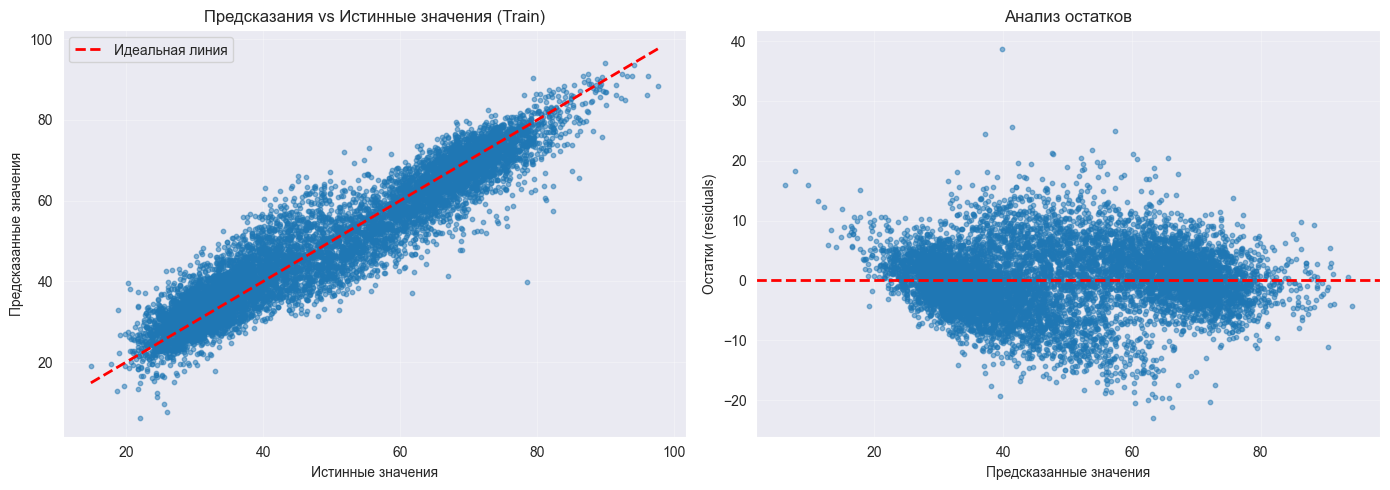


ИТОГОВОЕ СРАВНЕНИЕ МЕТОДОВ
           Метод       MSE      MAE       R²      MAPE
      Analytical 28.780285 4.083148 0.903086  9.432244
Gradient Descent 37.169978 4.785816 0.874835 11.222132
             SGD 30.405812 4.213423 0.897613  9.741099
         Sklearn 28.780285 4.083148 0.903086  9.432244

 ОСНОВНАЯ МЕТРИКА:
MSE на обучающей выборке: 28.7803


In [133]:
# График предсказаний vs истинных значений
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# График 1: Scatter plot
axes[0].scatter(y_train, y_train_pred, alpha=0.5, s=10)
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()],
             'r--', lw=2, label='Идеальная линия')
axes[0].set_xlabel('Истинные значения')
axes[0].set_ylabel('Предсказанные значения')
axes[0].set_title('Предсказания vs Истинные значения (Train)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# График 2: Residuals
residuals = y_train - y_train_pred
axes[1].scatter(y_train_pred, residuals, alpha=0.5, s=10)
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Предсказанные значения')
axes[1].set_ylabel('Остатки (residuals)')
axes[1].set_title('Анализ остатков')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "=" * 80)
print("ИТОГОВОЕ СРАВНЕНИЕ МЕТОДОВ")
print("=" * 80)

comparison_results = []

# Analytical
model_analytical = LinearRegressionCustom(method='analytical')
model_analytical.fit(X_train_normalized, y_train)
y_pred_analytical = model_analytical.predict(X_train_normalized)
comparison_results.append({
    'Метод': 'Analytical',
    'MSE': mse_custom(y_train, y_pred_analytical),
    'MAE': mae_custom(y_train, y_pred_analytical),
    'R²': r2_custom(y_train, y_pred_analytical),
    'MAPE': mape_custom(y_train, y_pred_analytical)
})

# Gradient Descent
model_gd = LinearRegressionCustom(method='gradient_descent', learning_rate=0.01, n_iterations=2000)
model_gd.fit(X_train_normalized, y_train)
y_pred_gd = model_gd.predict(X_train_normalized)
comparison_results.append({
    'Метод': 'Gradient Descent',
    'MSE': mse_custom(y_train, y_pred_gd),
    'MAE': mae_custom(y_train, y_pred_gd),
    'R²': r2_custom(y_train, y_pred_gd),
    'MAPE': mape_custom(y_train, y_pred_gd)
})

# SGD
model_sgd = LinearRegressionCustom(method='sgd', learning_rate=0.01, n_iterations=2000, batch_size=32)
model_sgd.fit(X_train_normalized, y_train)
y_pred_sgd = model_sgd.predict(X_train_normalized)
comparison_results.append({
    'Метод': 'SGD',
    'MSE': mse_custom(y_train, y_pred_sgd),
    'MAE': mae_custom(y_train, y_pred_sgd),
    'R²': r2_custom(y_train, y_pred_sgd),
    'MAPE': mape_custom(y_train, y_pred_sgd)
})

# Sklearn
sklearn_model = LinearRegression()
sklearn_model.fit(X_train_normalized, y_train)
y_pred_sklearn = sklearn_model.predict(X_train_normalized)
comparison_results.append({
    'Метод': 'Sklearn',
    'MSE': mean_squared_error(y_train, y_pred_sklearn),
    'MAE': mean_absolute_error(y_train, y_pred_sklearn),
    'R²': r2_score(y_train, y_pred_sklearn),
    'MAPE': mape_custom(y_train, y_pred_sklearn)
})

comparison_df = pd.DataFrame(comparison_results)
print(comparison_df.to_string(index=False))

print("\n ОСНОВНАЯ МЕТРИКА:")
print(f"MSE на обучающей выборке: {mse_custom(y_train, y_train_pred):.4f}")